# 长短期记忆网络（LSTM）



| 参数           | 值    | 含义                 |
| ------------ | ---- | ------------------ |
| `batch_size` | `32` | 每个批量包含32个独立序列样本    |
| `num_steps`  | `35` | 每个序列的长度为35个时间步（字符） |


In [1]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size, num_steps = 32, 35
'''
train_iter:数据迭代器（DataLoader）
每次迭代返回一个批量 (X,Y)
X:输入序列，形状 (batch_size,num_steps)
Y:目标序列（X的偏移），形状相同
vocab: 词汇表（Vocab对象）
将字符映射到索引（如'a'→ 1,'b'→2）,提供vocab.idx_to_token和vocab.token_to_idx方法
'''
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

初始化模型参数

| 门控                           | 参数   | 变量名    | 形状                           | 作用                       |
| ---------------------------- | ---- | ------ | ---------------------------- | ------------------------ |
| **输入门**<br>(Input Gate)      | 输入权重 | `W_xi` | `(vocab_size, num_hiddens)`  | 控制**新信息**写入记忆单元的程度       |
|                              | 隐藏权重 | `W_hi` | `(num_hiddens, num_hiddens)` |                          |
|                              | 偏置   | `b_i`  | `(num_hiddens,)`             |                          |
| **遗忘门**<br>(Forget Gate)     | 输入权重 | `W_xf` | `(vocab_size, num_hiddens)`  | 控制**旧信息**从记忆单元中**遗忘**的程度 |
|                              | 隐藏权重 | `W_hf` | `(num_hiddens, num_hiddens)` |                          |
|                              | 偏置   | `b_f`  | `(num_hiddens,)`             |                          |
| **输出门**<br>(Output Gate)     | 输入权重 | `W_xo` | `(vocab_size, num_hiddens)`  | 控制记忆单元**输出**到隐藏状态的程度     |
|                              | 隐藏权重 | `W_ho` | `(num_hiddens, num_hiddens)` |                          |
|                              | 偏置   | `b_o`  | `(num_hiddens,)`             |                          |
| **候选记忆**<br>(Candidate Cell) | 输入权重 | `W_xc` | `(vocab_size, num_hiddens)`  | 生成**新的候选记忆内容**           |
|                              | 隐藏权重 | `W_hc` | `(num_hiddens, num_hiddens)` |                          |
|                              | 偏置   | `b_c`  | `(num_hiddens,)`             |                          |


In [2]:
'''
vocab_size:词汇表大小（输入/输出维度）
num_hiddens:隐藏状态维度
device:计算设备
'''
def get_lstm_params(vocab_size, num_hiddens, device):
    # 语言模型中：输入是词索引的one-hot向量，输出是下一个词的概率分布，维度都等于词汇表大小
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        # 生成均值为0、标准差为0.01的正态分布随机数
        # 符合Xavier/Glorot初始化思想，防止梯度消失/爆炸
        return torch.randn(size=shape, device=device)*0.01

    def three():
        return (normal((num_inputs, num_hiddens)), # 输入权重
                normal((num_hiddens, num_hiddens)), # 隐藏权重
                torch.zeros(num_hiddens, device=device)) # 零偏置

    W_xi, W_hi, b_i = three() # 输入门参数
    W_xf, W_hf, b_f = three() # 遗忘门参数
    W_xo, W_ho, b_o = three() # 输出门参数
    W_xc, W_hc, b_c = three() # 候选记忆元参数
    # 将最后一个时间步的隐藏状态映射到输出空间;输出维度=词汇表大小，用于计算每个词的概率
    W_hq = normal((num_hiddens, num_outputs)) # 形状: (隐藏维度, 词表大小)
    b_q = torch.zeros(num_outputs, device=device) # 形状: (词表大小,)
    # 4个门×3个参数=12个;输出层2个;总计14个（比GRU多3个，因为多了一个门控）
    params = [W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc,
              b_c, W_hq, b_q]
    for param in params:
        param.requires_grad_(True) # 允许自动求导
    return params

初始化函数

In [3]:
'''
batch_size:批量大小（一次处理的序列数量）
num_hiddens:隐藏状态与记忆单元的维度
device:计算设备（CPU/GPU）
为什么需要两个状态？
LSTM的核心设计是解耦短期记忆与长期记忆：
Ht(Hidden State): 短期记忆，直接参与输出计算，像"工作记忆"
Ct(Cell State): 长期记忆，像一条信息传送带，被门控精细调节
这种分离设计让LSTM能更好地捕捉长期依赖关系。
初始化细节
全零初始化：最常见的实践，表示"初始无记忆"
独立初始化：H0和C0是两个独立张量，后续会分别更新
设备一致性：必须在同一设备上，避免运行时错误
'''
def init_lstm_state(batch_size, num_hiddens, device):
    '''
    返回一个包含两个张量的元组：
    第一个张量：H0（隐藏状态），形状(batch_size,num_hiddens)
    第二个张量：C0（记忆单元），形状(batch_size,num_hiddens)
    '''
    return (torch.zeros((batch_size, num_hiddens), device=device),
            torch.zeros((batch_size, num_hiddens), device=device))

实际模型

| 特性       | LSTM                                              | GRU                                                   |
| -------- | ------------------------------------------------- | ----------------------------------------------------- |
| **状态数**  | 两个（H + C）                                         | 一个（H）                                                 |
| **门数量**  | 3个门（I/F/O）                                        | 2个门（Z/R）                                              |
| **记忆机制** | **独立Cell State**，精细控制                             | 隐藏状态直接融合                                              |
| **计算量**  | 更高（4个矩阵乘/步）                                       | 较低（3个矩阵乘/步）                                           |
| **公式**   | $C_t = F_t \odot C_{t-1} + I_t \odot \tilde{C}_t$ | $H_t = Z_t \odot H_{t-1} + (1-Z_t) \odot \tilde{H}_t$ |


| 计算       | 公式                                      | 作用                | 输出形状                        |
| -------- | --------------------------------------- | ----------------- | --------------------------- |
| **输入门**  | `I = sigmoid(X@W_xi + H@W_hi + b_i)`    | 控制**新信息**写入C的比例   | `(batch_size, num_hiddens)` |
| **遗忘门**  | `F = sigmoid(X@W_xf + H@W_hf + b_f)`    | 控制**旧信息**从C中遗忘的比例 | 同上                          |
| **输出门**  | `O = sigmoid(X@W_xo + H@W_ho + b_o)`    | 控制C**输出**到H的比例    | 同上                          |
| **候选记忆** | `C_tilda = tanh(X@W_xc + H@W_hc + b_c)` | 生成**新候选记忆内容**     | 同上                          |


假设有h个隐藏单元，批量大小为n，输入数为d。因此，输入为$X_{t} \in \mathbb{R}^{n \times d}$，前一时间步的隐状态为$H_{t-1} \in \mathbb{R}^{n \times h}$。相应地，时间步t的门被定义如下：输入门是$I_{t} \in \mathbb{R}^{n \times h}$，遗忘门是$F_{t} \in \mathbb{R}^{n \times h}$，输出门是$O_{t} \in \mathbb{R}^{n \times h}$。它们的计算方法如下：<br>
$I_{t}=\sigma (X_{t}W_{xi}+H_{t-1}W_{hi}+b_{i})$<br>
$F_{t}=\sigma (X_{t}W_{xf}+H_{t-1}W_{hf}+b_{f})$<br>
$O_{t}=\sigma (X_{t}W_{xo}+H_{t-1}W_{ho}+b_{o})$<br>
其中$W_{xi},W_{xf},W_{xo} \in \mathbb{R}^{d \times h}$和$W_{hi},W_{hf},W_{ho} \in \mathbb{R}^{h \times h}$是权重参数，$b_{i},b_{f},b_{o} \in \mathbb{R}^{1 \times h}$是偏置参数。

由于还没有指定各种门的操作，所以先介绍候选记忆元（candidate memory cell）$\tilde{C}_{t}\in \mathbb{R} ^{n\times h} $。它的计算与上面描述的三个门的计算类似，但是使用tanh函数作为激活函数，函数的值范围为(-1,1)。下面导出在时间步t处的方程：<br>
$\tilde {C}_{t}=tanh(X_{t}W_{xc}+H_{t-1}W_{hc}+b_{c})$<br>
其中$W_{xc} \in \mathbb{R}^{d \times h}$和$W_{hc} \in \mathbb{R}^{h \times h}$是权重参数，$b_{c} \in \mathbb{R}^{1 \times h}$是偏置参数。

在门控循环单元中，有一种机制来控制输入和遗忘（或跳过）。类似地，在长短期记忆网络中，也有两个门用于这样的目的：输入门$I_{t}$
控制采用多少来自$\tilde{C}_{t}$的新数据，而遗忘门$F_{t}$控制保留多少过去的记忆元$C_{t-1} \in \mathbb{R}^{n \times h}$的内容。使用按元素乘法，得出：<br>
$C_{t}=F_{t}\odot C_{t-1}+I_{t}\odot \tilde{C}_{t}$<br>
如果遗忘门始终为1且输入门始终为0， 则过去的记忆元$C_{t-1}$将随时间被保存并传递到当前时间步。引入这种设计是为了缓解梯度消失问题，并更好地捕获序列中的长距离依赖关系。

最后，我们需要定义如何计算隐状态$H_{t}\in \mathbb {n\times h}$，这就是输出门发挥作用的地方。在长短期记忆网络中，它仅仅是记忆元的tanh的门控版本。这就确保了$H_{t}$的值始终在区间(-1,1)内：<br>
$H_{t}=O_{t}\odot tanh(C_{t})$<br>
只要输出门接近1，我们就能够有效地将所有记忆信息传递给预测部分，而对于输出门接近0，我们只保留记忆元内的所有信息，而不需要更新隐状态。

In [4]:
'''
输入X_t → [遗忘门F] → 决定忘记哪些旧记忆
      ↘ [输入门I] → 决定写入哪些新记忆
      ↘ [候选记忆C̃] → 生成新内容
      ↘ [记忆单元C] → C_t = F·C_{t-1} + I·C̃_t (长期记忆)
      ↘ [输出门O] → 决定从C中读取多少到H
      ↘ [隐藏状态H] → H_t = O·tanh(C_t) (短期记忆)
      ↘ [输出层] → Y_t
inputs:输入序列（形状:时间步数,批量大小,词表维度）
state:初始状态，包含(H_0,C_0) 两个张量
params:14个可训练参数列表（来自get_lstm_params()）
'''
def lstm(inputs, state, params):
    # 解包14个参数（4个门×3个参数+输出层2个）;H:隐藏状态（短期记忆），C:记忆单元（长期记忆）
    [W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc, b_c,
     W_hq, b_q] = params
    (H, C) = state
    outputs = []
    for X in inputs: # X形状: (批量大小, 词表维度)
        I = torch.sigmoid((X @ W_xi) + (H @ W_hi) + b_i)
        F = torch.sigmoid((X @ W_xf) + (H @ W_hf) + b_f)
        O = torch.sigmoid((X @ W_xo) + (H @ W_ho) + b_o)
        C_tilda = torch.tanh((X @ W_xc) + (H @ W_hc) + b_c)
        '''
        F⊙C:保留的旧记忆（遗忘门筛选）
        I⊙Ctilda:写入的新记忆（输入门筛选）
        效果像可微分的"记忆控制器"，精准控制信息增删
        '''
        C = F * C + I * C_tilda
        # tanh(C):将记忆单元压缩到[-1,1];O⊙tanh(C):输出门决定哪些记忆参与当前输出
        H = O * torch.tanh(C)
        # 将隐藏状态映射到输出空间（如词表概率）;Y形状: (批量大小,词表大小)
        Y = (H @ W_hq) + b_q
        outputs.append(Y)
    '''
    torch.cat(...,dim=0):将所有时间步输出拼接为 (时间步数×批量大小,词表大小)，便于一次性计算交叉熵损失
    (H,C):最终状态，供下一个序列继续使用
    '''
    return torch.cat(outputs, dim=0), (H, C)

训练

perplexity 1.1, 10395.3 tokens/sec on cuda:0
time traveller for so it will betwerit t momthe beccoriccopsthar
traveller curseally i bur whyourstange here is a portrait o


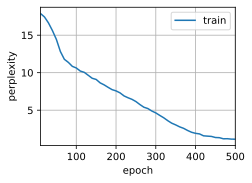

In [5]:
'''
数据加载 → 模型定义 → 参数初始化 → 状态初始化 → 前向传播 → 训练
     ↓            ↓            ↓              ↓            ↓        ↓
train_iter   RNNModelScratch  get_lstm_params  init_lstm_state  lstm  train_ch8
vocab_size:词汇表长度（字符种类数），来自load_data_time_machine返回的vocab
num_hiddens=256:隐藏状态维度，决定模型容量（可理解为记忆容量）
d2l.try_gpu():自动检测并使用GPU（如果可用），否则回退到CPU
'''
vocab_size, num_hiddens, device = len(vocab), 256, d2l.try_gpu()
num_epochs, lr = 500, 1 # 训练500轮（遍历整个数据集500次）;学习率设为1（非常大！但在简单RNN任务中有效）
'''
创建自定义LSTM模型，传入三个核心组件：
get_lstm_params:参数初始化函数（返回14个参数）
init_lstm_state:状态初始化函数（返回(H0,C0)）
lstm:前向传播函数（实现门控逻辑）
RNNModelScratch是d2l的包装类:保存模型参数和配置;在__call__中调用lstm函数;提供统一的模型接口
'''
model = d2l.RNNModelScratch(len(vocab), num_hiddens, device, get_lstm_params,
                            init_lstm_state, lstm)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

简洁实现

perplexity 1.0, 124177.9 tokens/sec on cuda:0
time travelleryou can show black is white by argument said filby
traveller with a slight accession ofcheerfulness really thi


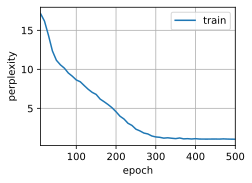

In [6]:
num_inputs = vocab_size
lstm_layer = nn.LSTM(num_inputs, num_hiddens)
model = d2l.RNNModel(lstm_layer, len(vocab))
model = model.to(device)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)